In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
log_name = "IF_track_20200315.txt"
with open(log_name, "r") as f:
    lines = f.readlines()

lines = [l.strip() for l in lines]

### RX fine codes vs. temperature

The temperature represents when the RX fine code was bumped up to that value while sweeping the temperature.

In [3]:
fine_codes_vs_temp = {
    2: 17.5,
    9: 19.2,
    10: 19.5,
    11: 20,
    12: 20.6,
    13: 20.9,
    14: 21.1,
    15: 21.9,
    17: 22.3,
    18: 22.7,
    19: 23.1,
    20: 23.6,
    22: 24.8,
    23: 25.6,
    24: 26.5,
    26: 27.5,
    27: 28.2,
    28: 29.5,
    29: 30.1
}

fine_codes = list(fine_codes_vs_temp.keys())
temp = list(fine_codes_vs_temp.values())

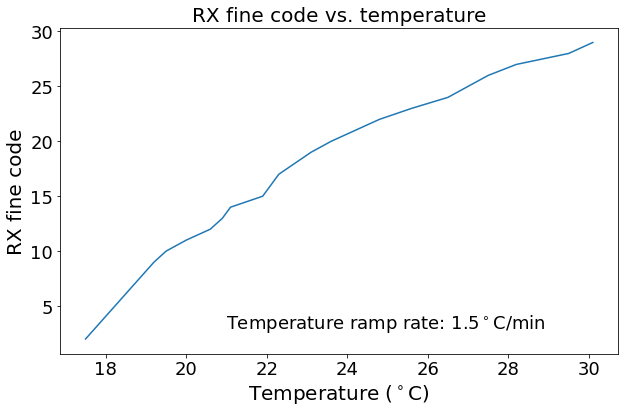

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(temp, fine_codes)
plt.xlabel("Temperature ($^\circ$C)", fontsize=20)
plt.ylabel("RX fine code", fontsize=20)
plt.title("RX fine code vs. temperature", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(21, 3, "Temperature ramp rate: 1.5$^\circ$C/min", fontsize=18)
plt.savefig("rx_fine_code_vs_temp.pdf", bbox_inches="tight")
plt.show()

### Filtered IF offset and TX/RX fine codes vs. time

The temperature ramp rate was 1.5C/min.

In [5]:
# Every 800ms, a line with "RX fine: %d, TX fine: %d" is printed.
time_delta = 0.8 # 800ms

match_template = r"RX fine: (\d+), TX fine: (\d+)"
IF_template = r"IF offset: (-?\d+), previous IF offset: (-?\d+)"

In [6]:
# Two separate time arrays since IF offset is not always printed.
time_fine, RX_fine, TX_fine = [], [], []
time_IF, IF_offset = [], []

t = 0
for line in lines:
    match = re.search(match_template, line)
    if match is not None:
        rx, tx = match.groups()
        
        if int(rx) >= 0 and int(rx) < 32 and int(tx) >= 0 and int(tx) < 32:
            time_fine.append(t)
        
            RX_fine.append(int(rx))
            TX_fine.append(int(tx))

            IF_match = re.search(IF_template, line)
            if IF_match is not None:
                time_IF.append(t)

                offset, prev_offset = IF_match.groups()
                IF_offset.append(int(offset))
        
        t += time_delta

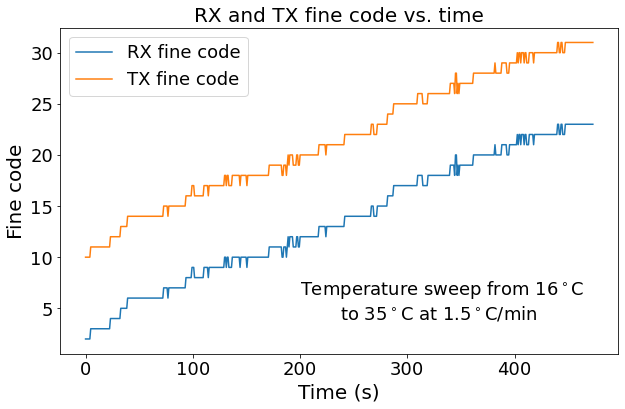

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(time_fine, RX_fine, label="RX fine code")
plt.plot(time_fine, TX_fine, label="TX fine code")
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Fine code", fontsize=20)
plt.title("RX and TX fine code vs. time", fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(200, 4, "Temperature sweep from 16$^\circ$C\n       to 35$^\circ$C at 1.5$^\circ$C/min", fontsize=18)
plt.savefig("rx_tx_fine_code_vs_time.pdf", bbox_inches="tight")
plt.show()

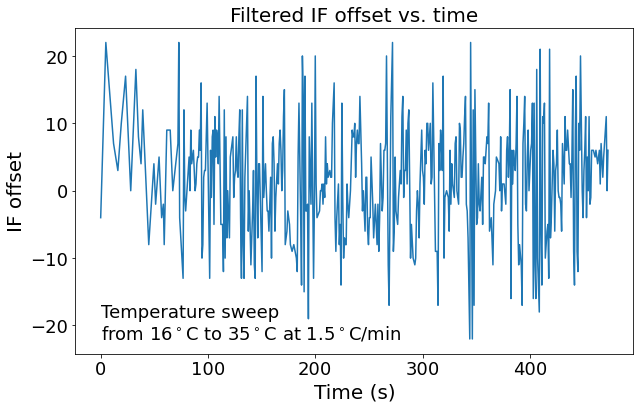

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(time_IF, IF_offset)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("IF offset", fontsize=20)
plt.title("Filtered IF offset vs. time", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(0, -22, "Temperature sweep\nfrom 16$^\circ$C to 35$^\circ$C at 1.5$^\circ$C/min", fontsize=18)
plt.savefig("if_offset_vs_time.pdf", bbox_inches="tight")
plt.show()

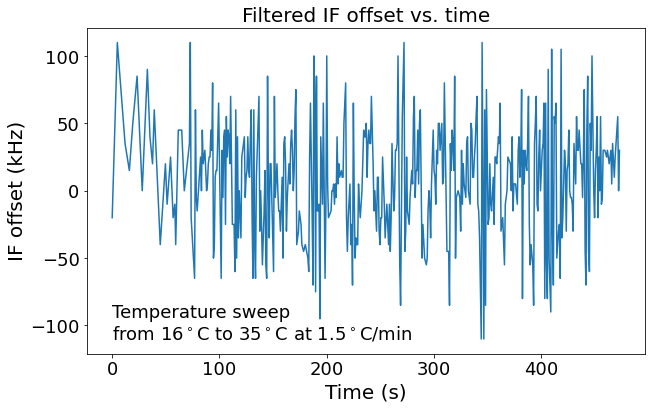

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time_IF, np.array(IF_offset) / 2 / 100e-6 / 1000)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("IF offset (kHz)", fontsize=20)
plt.title("Filtered IF offset vs. time", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(0, -110, "Temperature sweep\nfrom 16$^\circ$C to 35$^\circ$C at 1.5$^\circ$C/min", fontsize=18)
plt.savefig("if_offset_hz_vs_time.pdf", bbox_inches="tight")
plt.show()

### Raw IF estimate vs. time

The temperature ramp rate was 1.5C/min.

In [10]:
# Every 800ms, a line with "RX fine: %d, TX fine: %d" is printed.
time_delta = 0.8 # 800ms

match_template = r"RX fine: (\d+), TX fine: (\d+)"
IF_estimate_template = r"IF estimate: (-?\d+), LQI: (-?\d+)"

In [11]:
IF_estimates = []
time_IF_estimate = []

prev_t, t = 0, 0
temp_IF_estimates = []
for line in lines:
    time_match = re.search(match_template, line)
    if time_match is not None:
        rx, tx = time_match.groups()
        if int(rx) >= 32 or int(tx) >= 32:
            break
        
        t += time_delta
        
        time_IF_estimate.extend(list(np.linspace(prev_t, t, len(temp_IF_estimates), endpoint=False)))
        IF_estimates.extend(temp_IF_estimates)
        temp_IF_estimates = []
        
        prev_t = t
    
    IF_estimate_match = re.search(IF_estimate_template, line)
    if IF_estimate_match is not None:
        IF_estimate, LQI = IF_estimate_match.groups()
        if int(LQI) < 25:
            temp_IF_estimates.append(int(IF_estimate))

# Clear out the last IF estimates.
t += time_delta        
time_IF_estimate.extend(list(np.linspace(prev_t, t, len(temp_IF_estimates), endpoint=False)))
IF_estimates.extend(temp_IF_estimates)
temp_IF_estimates = []
            
IF_estimates = np.array(IF_estimates)
raw_IF_offsets = IF_estimates - 500

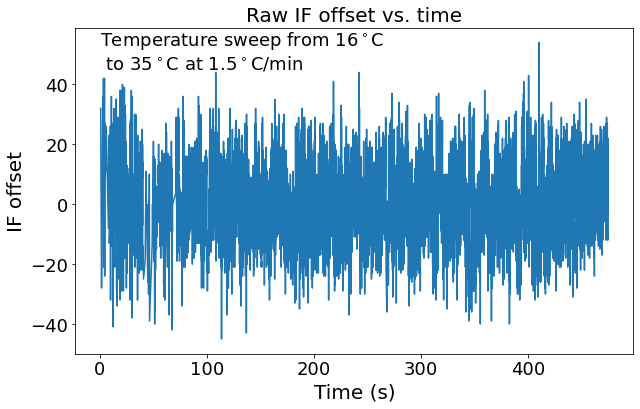

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(time_IF_estimate, raw_IF_offsets)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("IF offset", fontsize=20)
plt.title("Raw IF offset vs. time", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(0, 45, "Temperature sweep from 16$^\circ$C\n to 35$^\circ$C at 1.5$^\circ$C/min", fontsize=18)
plt.savefig("raw_if_offset_vs_time.pdf", bbox_inches="tight")
plt.show()